# 程式 10.1: 前處理函式

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import torchvision as TV
from IPython.display import clear_output

# 為了解決請求MNIST數據時出現403錯誤的問題
from six.moves import urllib 
opener = urllib.request.build_opener()
urllib.request.install_opener(opener)
###

mnist_data = TV.datasets.MNIST("MNIST/", train=True, transform=None,target_transform=None,download=True) #下載並匯入MNIST訓練資料
mnist_test = TV.datasets.MNIST("MNIST/", train=False, transform=None,target_transform=None,download=True) #下載並匯入MNIST測試資料

def add_spots(x,m=20,std=1,val=1): #在圖片中加入隨機雜點
  mask = torch.zeros(x.shape)
  N = int(m + std * np.abs(np.random.randn())) #隨機決定要加入的雜點數目 
  ids = np.random.randint(np.prod(x.shape),size=N )#隨機產生要加入雜點的索引
  mask.view(-1)[ids] = val #將索引對應的位置值設為1，代表一個雜點
  return torch.clamp(x + mask,0,1) #將雜點加入資料，並限制每個像素值在0和1之間

def prepare_images(xt,maxtrans=6,rot=5,noise=10): 
  out = torch.zeros(xt.shape)
  for i in range(xt.shape[0]):
    img = xt[i].unsqueeze(dim=0) #在第0階加入1個階
    img = TV.transforms.functional.to_pil_image(img)#將img轉換成PIL圖片
    rand_rot = np.random.randint(-1*rot,rot,1) if rot > 0 else 0 #隨機決定圖片旋轉的角度
    xtrans,ytrans = np.random.randint(-maxtrans,maxtrans,2)#隨機決定x方向及y方向的平移量
    rand_rot = int(rand_rot)
    xtrans = int(xtrans)
    ytrans = int(ytrans)
    img = TV.transforms.functional.affine(img, rand_rot, (xtrans,ytrans),1,0)
    img = TV.transforms.functional.to_tensor(img).squeeze()
    if noise > 0:
      img = add_spots(img,m=noise)
    maxval = img.view(-1).max()#取出img最後一階之最大值
    if maxval > 0:
      img = img.float() / maxval
    else:
      img = img.float()
    out[i] = img
  return out

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST\raw\train-images-idx3-ubyte.gz to MNIST/MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST\raw\train-labels-idx1-ubyte.gz to MNIST/MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST/MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST/MNIST\raw



## 輸出圖10.14中之原始圖片

D:\Anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


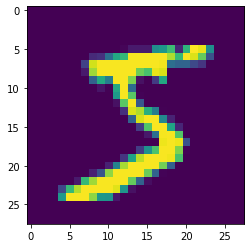

In [2]:
from matplotlib import pyplot as plt
import numpy as np
x = mnist_data.train_data[0]
plt.imshow(x) 

## 輸出圖10.14中之原始圖片（相關參數有做調整）

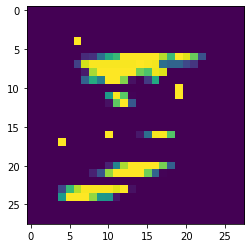

In [3]:
y = prepare_images(x,maxtrans=1,rot=1,noise=0.1)
plt.imshow(y)

# 程式 10.2 & 程式 10.3: 關聯性模組

In [4]:
###程式10.2###
class RelationalModule(torch.nn.Module):
  def __init__(self):
    super(RelationalModule, self).__init__()
    ###我們需要定義一些CNN層,幫助我們先將圖片資料處理成節點矩陣###
    self.ch_in = 1
    self.conv1_ch = 16 #定義每一層卷積層的通道數
    self.conv2_ch = 20
    self.conv3_ch = 24
    self.conv4_ch = 30
    self.H = 28 #圖片的高
    self.W = 28 #圖片的寬
    self.node_size = 36 #經過關聯性模組處理後，節點特徵向量的長度
    self.out_dim = 10
    self.sp_coord_dim = 2 #空間的維度數量（即x及y方向）
    self.N = int(16**2) #定義節點的數量，即圖片經過卷積層處理後的像素數量（●編註：**代表取平方）
    self.conv1 = nn.Conv2d(self.ch_in,self.conv1_ch,kernel_size=(4,4)) #4層CNN層
    self.conv2 = nn.Conv2d(self.conv1_ch,self.conv2_ch,kernel_size=(4,4))
    self.conv3 = nn.Conv2d(self.conv2_ch,self.conv3_ch,kernel_size=(4,4))
    self.conv4 = nn.Conv2d(self.conv3_ch,self.conv4_ch,kernel_size=(4,4))
    ###開始定義圖10.13中的投影層###
    self.proj_shape = (self.conv4_ch+self.sp_coord_dim,self.node_size) #每個節點向量的維度等於最後一層卷積層(conv4)的通道數加上空間維度
    self.k_proj = nn.Linear(*self.proj_shape) #3層線性投影層
    self.q_proj = nn.Linear(*self.proj_shape)
    self.v_proj = nn.Linear(*self.proj_shape)
    
    self.norm_shape = (self.N,self.node_size)
    self.k_norm = nn.LayerNorm(self.norm_shape, elementwise_affine=True) #正規化經過投影的query、key和value矩陣，提升訓練的穩定性
    self.q_norm = nn.LayerNorm(self.norm_shape, elementwise_affine=True)
    self.v_norm = nn.LayerNorm(self.norm_shape, elementwise_affine=True)
    
    self.linear1 = nn.Linear(self.node_size, self.node_size)
    self.norm1 = nn.LayerNorm([self.N,self.node_size], elementwise_affine=False)
    self.linear2 = nn.Linear(self.node_size, self.out_dim)

###程式10.3###
  def forward(self,x):
    N, Cin, H, W = x.shape
    ###先讓圖片資料通過卷積層，並處理成輸入至關聯性模組的節點矩陣###
    x = self.conv1(x) 
    x = torch.relu(x)
    x = self.conv2(x) 
    x = torch.relu(x) 
    x = self.conv3(x)
    x = torch.relu(x)
    x = self.conv4(x)
    x = torch.relu(x)

    _,_,cH,cW = x.shape
    xcoords = torch.arange(cW).repeat(cH,1).float() / cW #將每個節點的座標(x,y)加到其特徵向量中，並將向量值正規化到 [0,1] 的區間
    ycoords = torch.arange(cH).repeat(cW,1).transpose(1,0).float() / cH
    spatial_coords = torch.stack([xcoords,ycoords],dim=0)
    spatial_coords = spatial_coords.unsqueeze(dim=0)
    spatial_coords = spatial_coords.repeat(N,1,1,1) 
    x = torch.cat([x,spatial_coords],dim=1)
    x = x.permute(0,2,3,1) #將不同階的順序對調（由N,C,H,W變成N,H,W,C）
    x = x.flatten(1,2) #將第1階和第2階的元素整合在一起
    ###以下程式為投影層之操作###
    K = self.k_proj(x) #將輸入節點矩陣投影成鍵、問題與值矩陣
    K = self.k_norm(K) 

    Q = self.q_proj(x)
    Q = self.q_norm(Q) 

    V = self.v_proj(x)
    V = self.v_norm(V) 
    ###以下程式為產生attention權重矩陣之操作###
    A = torch.einsum('bfe,bge->bfg',Q,K) #對query矩陣與key矩陣進行批次矩陣相乘，產生attention權重矩陣
    A = A / np.sqrt(self.node_size) #正規化attention權重矩陣的元素
    A = torch.nn.functional.softmax(A,dim=2) 
    with torch.no_grad():
        self.att_map = A.clone()
    ###最後對attention權重矩陣及value矩陣進行張量收縮處理###    
    E = torch.einsum('bfc,bcd->bfd',A,V) #對attention權重矩陣與value矩陣進行批次矩陣相乘
    E = self.linear1(E)
    E = torch.relu(E)
    E = self.norm1(E)  
    E = E.max(dim=1)[0]
    y = self.linear2(E)  
    y = torch.nn.functional.log_softmax(y,dim=1)
    return y

# 程式 10.4: MNIST訓練迴圈

In [5]:
agent = RelationalModule() #建立relational模組的實例
epochs = 1000
batch_size = 300
lr = 1e-3
opt = torch.optim.Adam(params=agent.parameters(),lr=lr)
lossfn = nn.NLLLoss()
losses = []
acc = []

for i in range(epochs):
  print("epoch:",i)
  opt.zero_grad()
  batch_ids = np.random.randint(0,60000,size=batch_size) #產生要從MNIST圖片集中選擇的子集索引
  xt = mnist_data.data[batch_ids].detach() #產生訓練批次
  xt = prepare_images(xt,rot=30).unsqueeze(dim=1) #使用之前定義的prepare_images( )對批次中的圖片進行轉換處理，最大旋轉角度為30度
  yt = mnist_data.train_labels[batch_ids].detach()
  pred = agent(xt)
  pred_labels = torch.argmax(pred,dim=1) #圖片標籤等於輸出向量經argmax( )處理後的結果
  acc_ = 100.0 * (pred_labels == yt).sum() / batch_size #計算模型對訓練批次的預測準確率
  acc.append(acc_)
  correct = torch.zeros(batch_size,10)
  rows = torch.arange(batch_size).long()
  correct[[rows,yt.detach().long()]] = 1.
  loss = lossfn(pred,yt)
  losses.append(loss)
  loss.backward()
  opt.step()
  clear_output(wait=True)

epoch: 999


## 將結果視覺化

In [6]:
def trans1d(source):
    '''将带有梯度的一维张量列表转换成np.array'''
    l = []
    for i in range(len(source)):
        l.append(float(source[i].detach().numpy()))
    return np.array(l)

In [7]:
losses = trans1d(losses)
acc = trans1d(acc)

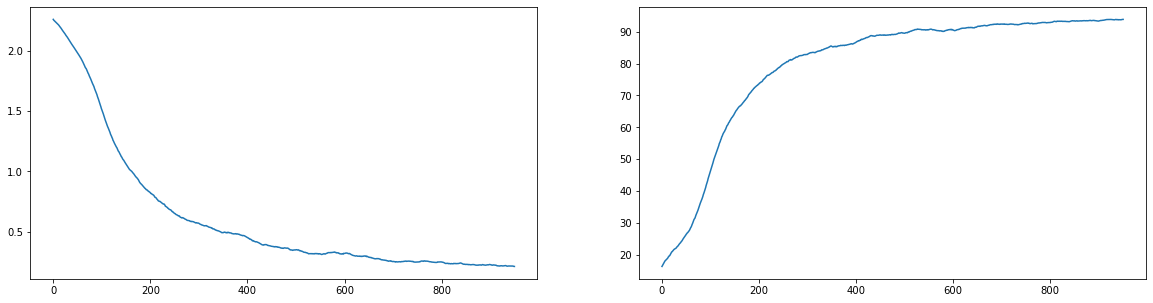

In [8]:
def running_mean(x,w=50,step=1):
  c = 1.0/w
  conv = np.array([c]).repeat(w)
  output = []
  s,e = 0,w
  for i in range(x.shape[0]):
    sub = x[s:e]
    if sub.shape[0] < w:
      break
    tmp = conv @ sub
    output.append(tmp)
    s = s + step
    e = s + w
  return np.array(output)
    
fig,ax = plt.subplots(1,2)
fig.set_size_inches(20,5)
ax[0].plot(running_mean(losses))
ax[1].plot(running_mean(acc))

# 程式 10.5: MNIST測試準確率

In [9]:
def test_acc(model,batch_size=500):
  acc = 0.
  batch_ids = np.random.randint(0,10000,size=batch_size) #隨機從測試資料集中選取測試子集
  xt = mnist_test.test_data[batch_ids].detach()
  xt = prepare_images(xt,maxtrans=6,rot=30,noise=10).unsqueeze(dim=1)
  yt = mnist_test.test_labels[batch_ids].detach()
  preds = model(xt)
  pred_ind = torch.argmax(preds.detach(),dim=1)
  acc = (pred_ind == yt).sum().float() / batch_size
  return acc, xt, yt

acc2, xt2, yt2 = test_acc(agent)
print(f'\nAcc = {acc2*100} %')

D:\Anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
D:\Anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")



Acc = 94.0 %


# 程式 10.6: 在MNIST任務中做為比較基準的卷積神經網路

In [10]:
class CNN(torch.nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1,10,kernel_size=(4,4)) 
    self.conv2 = nn.Conv2d(10,16,kernel_size=(4,4))
    self.conv3 = nn.Conv2d(16,24,kernel_size=(4,4))
    self.conv4 = nn.Conv2d(24,32,kernel_size=(4,4))
    self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2)) #對前4層卷積層的輸出結果進行池化處理
    self.conv5 = nn.Conv2d(32,64,kernel_size=(4,4))
    self.lin1 = nn.Linear(256,128)
    self.out = nn.Linear(128,10) #模型的最後一層為線性層，用來處理CNN扁平化後的輸出
  def forward(self,x):
    x = self.conv1(x)
    x = nn.functional.relu(x)
    x = self.conv2(x)
    x = nn.functional.relu(x)
    x = self.maxpool1(x)
    x = self.conv3(x)
    x = nn.functional.relu(x)
    x = self.conv4(x)
    x = nn.functional.relu(x)
    x = self.conv5(x)
    x = nn.functional.relu(x)
    x = x.flatten(start_dim=1)
    x = self.lin1(x)
    x = nn.functional.relu(x)
    x = self.out(x)
    x = nn.functional.log_softmax(x,dim=1) #使用log_softmax( )，以機率的形式進行分類
    return x

## 測試CNN（將程式10.4中的代理人改成CNN模組）

In [11]:
agent_CNN = CNN() #建立CNN模組的實例
epochs = 1000
batch_size=300
lr = 1e-3
opt = torch.optim.Adam(params=agent_CNN.parameters(),lr=lr)
lossfn = nn.NLLLoss()
##
losses = []
acc_CNN = []

for i in range(epochs):
  print(i)
  clear_output(wait=True)
  opt.zero_grad()
  batch_ids_CNN = np.random.randint(0,60000,size=batch_size) #產生要從MNIST圖片集中選擇的子集索引
  xt = mnist_data.data[batch_ids_CNN].detach() #產生訓練批次
  xt = prepare_images(xt,rot=30).unsqueeze(dim=1) #使用之前定義的prepare_images( )對批次中的圖片進行轉換處理，最大旋轉角度為30度
  yt = mnist_data.train_labels[batch_ids_CNN].detach()
  pred = agent_CNN(xt)
  pred_labels = torch.argmax(pred,dim=1) #圖片標籤等於輸出向量經argmax( )處理後的結果
  acc_ = 100.0 * (pred_labels == yt).sum() / batch_size #計算模型對訓練批次的預測準確率
  acc_CNN.append(acc_)
  correct = torch.zeros(batch_size,10)
  rows = torch.arange(batch_size).long()
  correct[[rows,yt.detach().long()]] = 1.
  loss = lossfn(pred,yt)
  losses.append(loss)    
  loss.backward()
  opt.step()

999


In [12]:
losses = trans1d(losses)

In [13]:
acc_CNN = trans1d(acc_CNN)

In [14]:
acc2, xt2, yt2 = test_acc(agent_CNN)
print(f'\nAcc = {acc2*100} %')


Acc = 89.4000015258789 %


##視覺化attention權重矩陣

D:\Anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


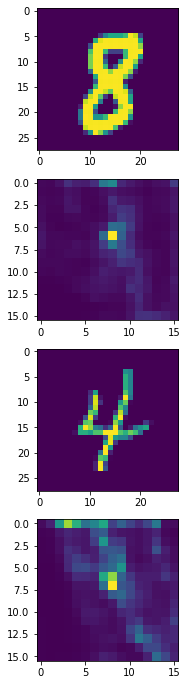

In [15]:
x = mnist_data.train_data[batch_ids[30]]
x_change = agent.att_map[30].max(dim=0)[0].view(16,16)
y = mnist_data.train_data[batch_ids[2]]
y_change = agent.att_map[2].max(dim=0)[0].view(16,16)
f,out = plt.subplots(4,1,figsize=(12,12))
out[0].imshow(x)
out[1].imshow(x_change)
out[2].imshow(y)
out[3].imshow(y_change)

In [16]:
pip install gym-minigrid

In [17]:
pip install einops

Note: you may need to restart the kernel to use updated packages.


In [18]:
from einops import rearrange
x = torch.randn(5,7,7,3)
rearrange(x, "batch h w c -> batch c h w").shape

torch.Size([5, 3, 7, 7])

In [19]:
x = torch.randn(5, 49, 3)
rearrange(x, "batch (h w) c -> batch h w c", h=7).shape

torch.Size([5, 7, 7, 3])

# 程式 10.7: 多端口關聯性模組

In [20]:
class MultiHeadRelationalModule(torch.nn.Module):
  def __init__(self):
    super(MultiHeadRelationalModule, self).__init__()
    self.conv1_ch = 16 
    self.conv2_ch = 20
    self.conv3_ch = 24
    self.conv4_ch = 30
    self.H = 28
    self.W = 28
    self.node_size = 64
    self.lin_hid = 100
    self.out_dim = 5
    self.ch_in = 3
    self.sp_coord_dim = 2
    self.N = int(7**2)
    self.n_heads = 3
    
    self.conv1 = nn.Conv2d(self.ch_in,self.conv1_ch,kernel_size=(1,1),padding=0) #使用1x1卷積以保留方格盤上各物件的空間關係
    self.conv2 = nn.Conv2d(self.conv1_ch,self.conv2_ch,kernel_size=(1,1),padding=0)
    self.proj_shape = (self.conv2_ch+self.sp_coord_dim,self.n_heads * self.node_size)
    self.k_proj = nn.Linear(*self.proj_shape)
    self.q_proj = nn.Linear(*self.proj_shape)
    self.v_proj = nn.Linear(*self.proj_shape)

    self.k_lin = nn.Linear(self.node_size,self.N) #建立加法attention所需的線性層
    self.q_lin = nn.Linear(self.node_size,self.N)
    self.a_lin = nn.Linear(self.N,self.N)
    
    self.node_shape = (self.n_heads, self.N,self.node_size)
    self.k_norm = nn.LayerNorm(self.node_shape, elementwise_affine=True)
    self.q_norm = nn.LayerNorm(self.node_shape, elementwise_affine=True)
    self.v_norm = nn.LayerNorm(self.node_shape, elementwise_affine=True)
    
    self.linear1 = nn.Linear(self.n_heads * self.node_size, self.node_size)
    self.norm1 = nn.LayerNorm([self.N,self.node_size], elementwise_affine=False)
    self.linear2 = nn.Linear(self.node_size, self.out_dim)
  
  def forward(self,x):
    N, Cin, H, W = x.shape
    x = self.conv1(x) 
    x = torch.relu(x)
    x = self.conv2(x) 
    x = torch.relu(x) 
    with torch.no_grad(): 
      self.conv_map = x.clone() #將卷積層處理完的結果存下來，以便日後視覺化呈現
    _,_,cH,cW = x.shape
    xcoords = torch.arange(cW).repeat(cH,1).float() / cW
    ycoords = torch.arange(cH).repeat(cW,1).transpose(1,0).float() / cH
    spatial_coords = torch.stack([xcoords,ycoords],dim=0)
    spatial_coords = spatial_coords.unsqueeze(dim=0)
    spatial_coords = spatial_coords.repeat(N,1,1,1)
    x = torch.cat([x,spatial_coords],dim=1)
    x = x.permute(0,2,3,1)
    x = x.flatten(1,2)
    
    K = rearrange(self.k_proj(x), "b n (head d) -> b head n d", head=self.n_heads)
    K = self.k_norm(K) 
    
    Q = rearrange(self.q_proj(x), "b n (head d) -> b head n d", head=self.n_heads)
    Q = self.q_norm(Q) 
    
    V = rearrange(self.v_proj(x), "b n (head d) -> b head n d", head=self.n_heads)
    V = self.v_norm(V) 
    A = torch.nn.functional.elu(self.q_lin(Q) + self.k_lin(K)) #加法attention
    A = self.a_lin(A)
    A = torch.nn.functional.softmax(A,dim=3) 
    with torch.no_grad():
      self.att_map = A.clone() #將attention權重存下來，以便日後視覺化呈現
    E = torch.einsum('bhfc,bhcd->bhfd',A,V) #對attention權重矩陣和節點矩陣進行批次矩陣乘法，進而產生更新後的節點矩陣
    E = rearrange(E, 'b head n d -> b n (head d)') #融合端口維度與特徵維度d
    E = self.linear1(E)
    E = torch.relu(E)
    E = self.norm1(E)
    E = E.max(dim=1)[0]
    y = self.linear2(E)
    y = torch.nn.functional.elu(y)
    return y

# 程式 10.8：前處理函式

In [21]:
import gym
from gym_minigrid.minigrid import *
from gym_minigrid.wrappers import FullyObsWrapper, ImgObsWrapper
from skimage.transform import resize

def prepare_state(x): #將狀態張量正規化，並轉換成張量
  ns = torch.from_numpy(x).float().permute(2,0,1).unsqueeze(dim=0)
  maxv = ns.flatten().max()
  ns = ns / maxv
  return ns

def get_minibatch(replay,size): #從經驗池中隨機選取一小批次量的資料
  batch_ids = np.random.randint(0,len(replay),size)
  batch = [replay[x] for x in batch_ids] #list of tuples
  state_batch = torch.cat([s for (s,a,r,s2,d) in batch],)
  action_batch = torch.Tensor([a for (s,a,r,s2,d) in batch]).long()
  reward_batch = torch.Tensor([r for (s,a,r,s2,d) in batch])
  state2_batch = torch.cat([s2 for (s,a,r,s2,d) in batch],dim=0)
  done_batch = torch.Tensor([d for (s,a,r,s2,d) in batch])
  return state_batch,action_batch,reward_batch,state2_batch, done_batch

def get_qtarget_ddqn(qvals,r,df,done): #計算目標Q值
  targets = r + (1-done) * df * qvals
  return targets

# 程式 10.9： 損失函數及經驗池

In [22]:
def lossfn(pred,targets,actions): #損失函數
  loss = torch.mean(torch.pow(targets.detach() - pred.gather(dim=1,index=actions.unsqueeze(dim=1)).squeeze(),2),dim=0)
  return loss
  
def update_replay(replay,exp,replay_size): #優先經驗回放機制
  r = exp[2] #從經驗經驗中取出回饋值資訊
  N = 1
  if r > 0: #若回饋值是正的，則把N設為50
    N = 50
  for i in range(N): #根據N的大小，決定複製的次數
    replay.append(exp)
  return replay

action_map = { #將DQN輸出的動作索引對應會用到的環境動作索引上
    0:0, 
    1:1,
    2:2,
    3:3,
    4:5,
}

# 程式 10.10： 主要訓練迴圈

In [23]:
from collections import deque
env = ImgObsWrapper(gym.make('MiniGrid-DoorKey-5x5-v0')) #建立環境
state = prepare_state(env.reset()) 
GWagent = MultiHeadRelationalModule() #建立主要DQN
Tnet = MultiHeadRelationalModule() #建立目標DQN
maxsteps = 400 #設定最大步數（超過即遊戲失敗）
env.max_steps = maxsteps
env.env.max_steps = maxsteps
epochs = 50000
replay_size = 9000
batch_size = 50
lr = 0.0005
gamma = 0.99
replay = deque(maxlen=replay_size) #建立經驗池
opt = torch.optim.Adam(params=GWagent.parameters(),lr=lr)
eps = 0.5
update_freq = 100
losses = []
steps = []
eplen = 0
done = False
count = 0
for i in range(epochs):
  eplen += 1
  pred = GWagent(state)
  action = int(torch.argmax(pred).detach().numpy())
  print("Training epochs:",i," Current episode length:",eplen,"\nGame won:",count," Game played:",len(steps))
  clear_output(wait=True)    
  if np.random.rand() < eps: #利用ε—貪婪策略選擇動作
    action = int(torch.randint(0,5,size=(1,)).squeeze())
  action_d = action_map[action]
  state2, reward, done, info = env.step(action_d)
  reward = -0.01 if reward == 0 else reward #將非終止狀態的獎勵值調整成很小的負值
  state2 = prepare_state(state2)
  exp = (state,action,reward,state2,done)      
  replay = update_replay(replay,exp,replay_size)
  if done:
    state = prepare_state(env.reset())
    steps.append(eplen)
    if(eplen < maxsteps):
      count += 1
    eplen = 0        
  else:
    state = state2
  if len(replay) > batch_size:        
    opt.zero_grad()        
    state_batch,action_batch,reward_batch,state2_batch,done_batch = get_minibatch(replay,batch_size)        
    q_pred = GWagent(state_batch).cpu()
    astar = torch.argmax(q_pred,dim=1)
    qs = Tnet(state2_batch).gather(dim=1,index=astar.unsqueeze(dim=1)).squeeze()        
    targets = get_qtarget_ddqn(qs.detach(),reward_batch.detach(),gamma,done_batch)   
    loss = lossfn(q_pred,targets.detach(),action_batch)
    losses.append(loss)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(GWagent.parameters(), max_norm=1.0) #對梯度進行裁切，以防止過大的梯度值
    opt.step()
  if i % update_freq == 0: #每100次訓練同步一次主要DQN與目標DQN
    Tnet.load_state_dict(GWagent.state_dict())

Training epochs: 49999  Current episode length: 14 
Game won: 578  Game played: 578


In [24]:
print(losses)

[tensor(0.2189, grad_fn=<MeanBackward1>), tensor(0.0760, grad_fn=<MeanBackward1>), tensor(0.0420, grad_fn=<MeanBackward1>), tensor(0.5257, grad_fn=<MeanBackward1>), tensor(0.4609, grad_fn=<MeanBackward1>), tensor(0.2283, grad_fn=<MeanBackward1>), tensor(0.2292, grad_fn=<MeanBackward1>), tensor(0.2216, grad_fn=<MeanBackward1>), tensor(0.1850, grad_fn=<MeanBackward1>), tensor(0.1955, grad_fn=<MeanBackward1>), tensor(0.1720, grad_fn=<MeanBackward1>), tensor(0.1180, grad_fn=<MeanBackward1>), tensor(0.0837, grad_fn=<MeanBackward1>), tensor(0.0714, grad_fn=<MeanBackward1>), tensor(0.0408, grad_fn=<MeanBackward1>), tensor(0.0156, grad_fn=<MeanBackward1>), tensor(0.0170, grad_fn=<MeanBackward1>), tensor(0.0124, grad_fn=<MeanBackward1>), tensor(0.0161, grad_fn=<MeanBackward1>), tensor(0.5468, grad_fn=<MeanBackward1>), tensor(0.5389, grad_fn=<MeanBackward1>), tensor(0.5633, grad_fn=<MeanBackward1>), tensor(0.5413, grad_fn=<MeanBackward1>), tensor(0.4571, grad_fn=<MeanBackward1>), tensor(0.3364, 

In [25]:
losses = trans1d(losses)

In [26]:
print(f'Percentage of victories = {count/len(steps)}')
steps = np.array(steps)

Percentage of victories = 1.0


## 將結果視覺化

Percentage of victories = 1.0


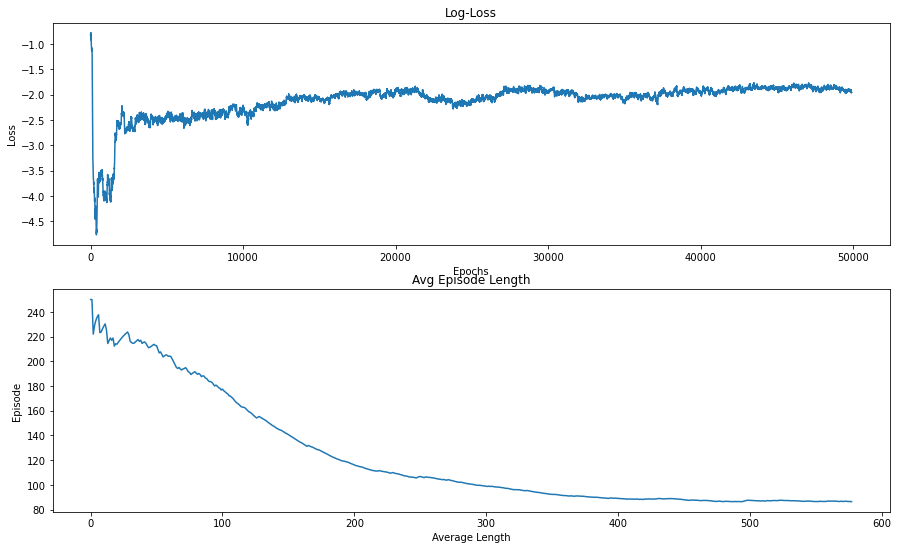

In [27]:
losses = np.array(losses)
print(f'Percentage of victories = {count/len(steps)}')
steps = np.array(steps)

sum = 0
average = []
for i in range(len(steps)):
  sum += steps[i]
  average.append(sum/(i+1))


fig,ax = plt.subplots(2,1)
fig.set_size_inches(15,9)
ax[0].set_title("Log-Loss")
ax[0].plot(running_mean(np.log10(np.array(losses))))
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[1].set_title("Avg Episode Length")
ax[1].set_xlabel("Average Length")
ax[1].set_ylabel("Episode")
ax[1].plot(average)

## 視覺化attention權重

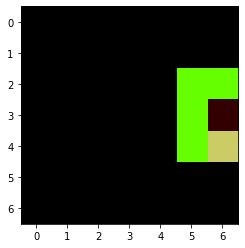

In [28]:
state_ = env.reset()
state = prepare_state(state_)
GWagent(state) #讓模型處理特定狀態
plt.imshow(env.render('rgb_array'))
plt.imshow(state[0].permute(1,2,0).detach().numpy())

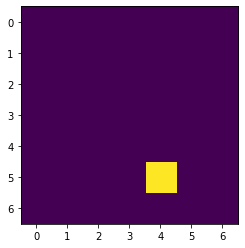

In [29]:
head, node = 2, 21 #選擇要視覺化的特定節點
plt.imshow(GWagent.att_map[0][head][node].view(7,7)) #將上述張量重塑成7×7的方格並畫出